In [14]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Evaluate the Encoder-Decoder models

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
from utils import sample_files, encdec_files_to_tensors
from utils import get_best_model_timestamp
from utils import unnormalize_params, minmax_normalize_param
from models import encoderDecoderModel

# data_dir = './tomo_data/datasets_decoder_TF_16-12-22'
data_dir = './tomo_data/datasets_decoder_TF_03-03-23'


dataset_percent = 0.05
normalization = 'minmax'
img_normalize = 'off'
ps_normalize = 'off'
var_names = ['phEr', 'enEr', 'bl', 'inten', 'Vrf', 'mu', 'VrfSPS']
loss_weights = [0, 1, 2, 3, 4, 5, 6]

# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
enc_timestamp = 'best_encoder_TF'
dec_timestamp = 'best_decoder_TF'



In [16]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)


# First the training data
file_names = sample_files(TESTING_PATH, dataset_percent)

start_t = time.time()
# read input, divide in features/ label, create tensors
wf_test, turn_test, latent_test, ps_test = encdec_files_to_tensors(
    file_names, normalization=normalization, img_normalize=img_normalize,
    ps_normalize=ps_normalize)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


Elapsed time: 120.031, Per file: 0.082


In [17]:
# drop column from y_train, y_valid
# latent_test = tf.concat([tf.expand_dims(tf.gather(latent_test, i, axis=1), axis=1)
#                         for i in loss_weights], -1)
# print('latent_test shape: ', latent_test.shape)


In [18]:
# Models to load
print('Encoder: ', enc_timestamp)

# Initialize directories
enc_trial_dir = os.path.join('./trials/', enc_timestamp)
enc_weights_dir = os.path.join(enc_trial_dir, 'weights')
assert os.path.exists(enc_weights_dir)

print('Decoder: ', dec_timestamp)

# Initialize directories
dec_trial_dir = os.path.join('./trials/', dec_timestamp)
dec_weights_dir = os.path.join(dec_trial_dir, 'weights')
assert os.path.exists(dec_weights_dir)

# initialize directory to save the plots
timestamp = f'enc_{enc_timestamp}_dec_{dec_timestamp}'
print('Timestamp: ', timestamp)
plots_dir = os.path.join('./plots', 'end_to_end', timestamp)
os.makedirs(plots_dir, exist_ok=True)

encDec = encoderDecoderModel(enc_weights_dir, dec_weights_dir, loss_weights=loss_weights)


Encoder:  best_encoder_TF
Decoder:  best_decoder_TF
Timestamp:  enc_best_encoder_TF_dec_best_decoder_TF


In [19]:

# Evaluate the model on the test and validation data
latent_pred, ps_pred = encDec.predictPS(wf_test, turn_test)
# Evaluate the latent space agreemet 
latent_mse = mean_squared_error(latent_test, latent_pred, multioutput='raw_values') 
print('Variable\tMSE')
for var_id, mse in zip(loss_weights, latent_mse):
    print(f'{var_names[var_id]}:\t{mse:.3e}')

# Evaluate the PS agreement
ps_enc_dec_mse = np.mean((ps_test - ps_pred)**2, axis=0).reshape((128, 128))
print('\nPS Encoder-Decoder MSE: ', np.mean(ps_enc_dec_mse))

# Evaluate the PS agreement with perfect encoder
ps_dec_pred = encDec.decode(latent_test, turn_test)
ps_dec_mse = np.mean((ps_test - ps_dec_pred)**2, axis=0).reshape((128, 128))
print('\nPS Decoder MSE: ', np.mean(ps_dec_mse))



Variable	MSE
phEr:	2.874e-06
enEr:	2.195e-05
bl:	1.839e-04
inten:	4.475e-06
Vrf:	2.638e-05
mu:	6.852e-04
VrfSPS:	1.254e-04

PS Encoder-Decoder MSE:  4.9067185e-06

PS Decoder MSE:  4.3584687e-06


In [20]:
# unormalized latent space
latent_unnorm = unnormalize_params(
    latent_test[:, 0], latent_test[:, 1], latent_test[:, 2],
    latent_test[:, 3], latent_test[:, 4], latent_test[:, 5],
    latent_test[:, 6], normalization=normalization)
latent_unnorm = np.array(latent_unnorm).T

# unormalized predicted latent space
latent_pred_unnorm = unnormalize_params(
    latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
    latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
    latent_pred[:, 6], normalization=normalization)
latent_pred_unnorm = np.array(latent_pred_unnorm).T

# absolute difference
diffs = np.abs(latent_unnorm - latent_pred_unnorm)


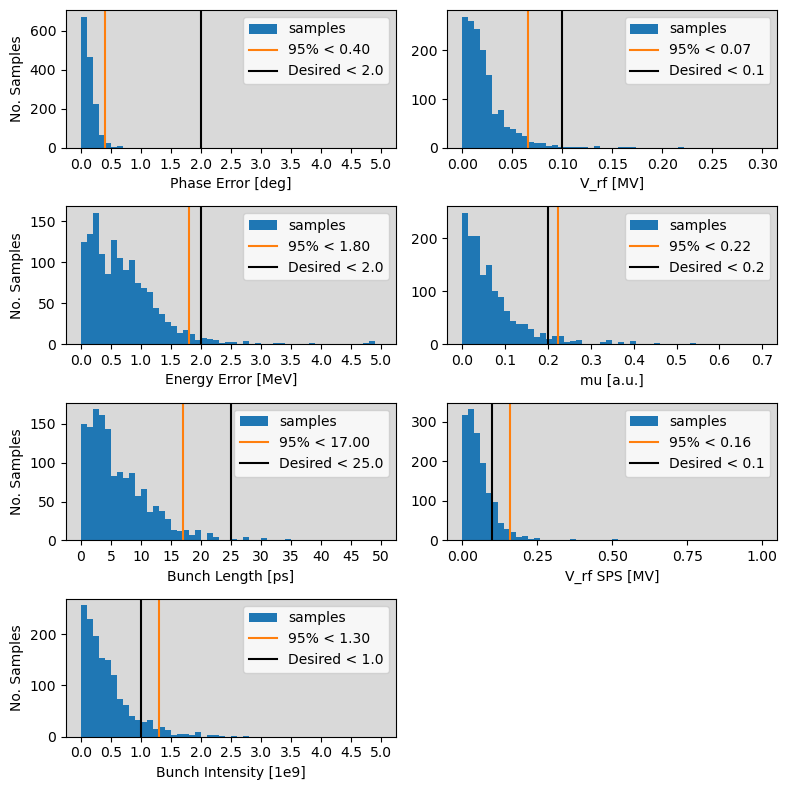

In [21]:
import bisect

# Encoder, graphical evaluation
evaluation_config = {
    0: {'xlabel': 'Phase Error [deg]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 2,
        'multiplier': 1},
    1: {'xlabel': 'Energy Error [MeV]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 2,
        'multiplier': 1},
    2: {'xlabel': 'Bunch Length [ps]',
        'range': (0, 50),
        'xticks': np.arange(0, 50.5, 5),
        'desired': 25,
        'multiplier': 1e12},
    3: {'xlabel': 'Bunch Intensity [1e9]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 1,
        'multiplier': 1e-9},
    4: {'xlabel': 'V_rf [MV]',
        'range': (0, 0.3),
        'xticks': np.arange(0, 0.31, 0.05),
        'desired': 0.1,
        'multiplier': 1},
    5: {'xlabel': 'mu [a.u.]',
        'range': (0, 0.7),
        'xticks': np.arange(0, 0.71, 0.1),
        'desired': 0.2,
        'multiplier': 1},
    6: {'xlabel': 'V_rf SPS [MV]',
        'range': (0, 1),
        'xticks': np.arange(0, 1.1, 0.25),
        'desired': 0.1,
        'multiplier': 1},
}

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=False,
                         sharey=False, figsize=(8, 8))
axes = np.ravel(axes, order='F')

for idx, ax in enumerate(axes):
    if idx == 7:
        break
    plt.sca(ax)
    config = evaluation_config[idx]
    hist, bins, _ = plt.hist(
        diffs[:, idx]*config['multiplier'], bins=50, range=config['range'], label='samples')
    cumsum = np.cumsum(hist) / diffs.shape[0]
    b = bisect.bisect(cumsum, 0.95)
    plt.axvline(x=bins[b+1], color='tab:orange',
                label=f'95% < {bins[b+1]:.2f}')
    plt.xticks(config['xticks'])
    plt.xlabel(config['xlabel'])
    if idx < 4:
        plt.ylabel('No. Samples')
    plt.axvline(x=config['desired'], color='black',
                label=f'Desired < {config["desired"]:.1f}')
    plt.legend(loc='upper right')
    plt.gca().set_facecolor('0.85')

# delete last
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, f'encoder_absError.jpg'), dpi=400, bbox_inches='tight')

PS True, min: 0.0, max: 0.05486628785729408
PS Pred, min: -0.0003271021996624768, max: 0.05105123668909073


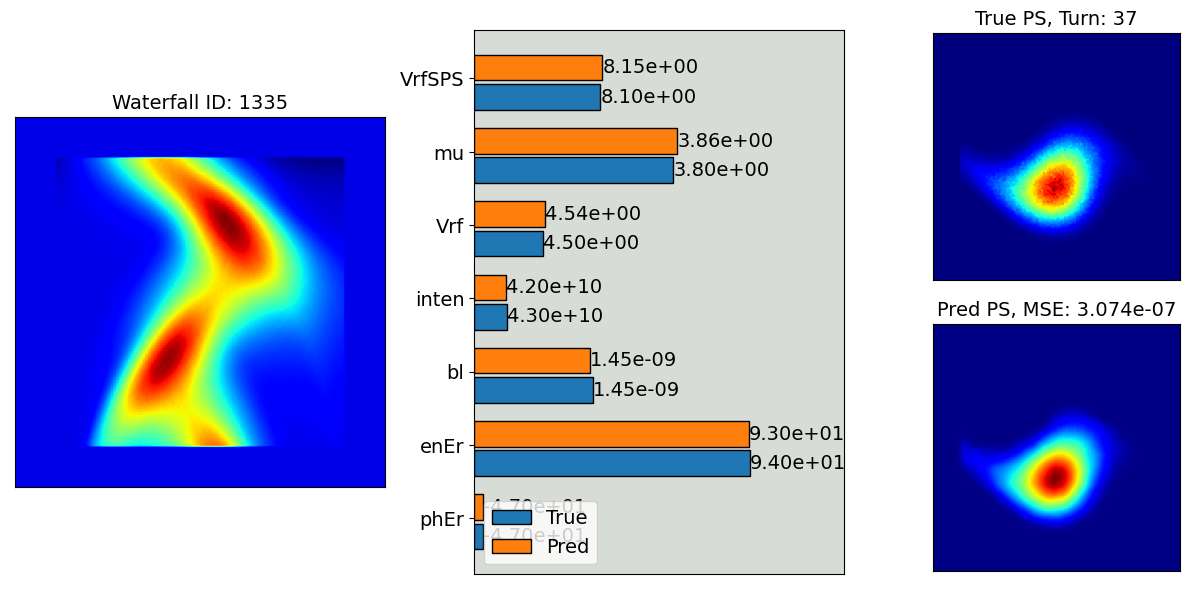

In [22]:
'''
Visual end-to-end evaluation. 
Left: Waterfall (input)
Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
'''
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'TAB', 'PS_TRUE'],
                                       ['WF', 'TAB', 'PS_PRED']],
                               gridspec_kw={'width_ratios': [3, 3, 2]},
                               #        'hspace': 0.1, 'wspace': 0.2},
                               figsize=(12, 6))

# fig, axes = plt.subplot_mosaic(mosaic=[['WF', 'WF', 'TAB'],
#                                        ['PS_TRUE', 'PS_PRED', 'TAB']],
#                                gridspec_kw={'width_ratios': [2, 2, 4]},
#                                #        'hspace': 0.1, 'wspace': 0.2},
#                                figsize=(8, 8))

# get random id
sample_id = np.random.randint(low=0, high=len(file_names))
wf_s = np.array(wf_test[sample_id]).reshape(128, 128).T
latent_true_s = latent_unnorm[sample_id]
latent_pred_s = latent_pred_unnorm[sample_id]
latent_norm_true_s = np.array(latent_test[sample_id])
latent_norm_pred_s = np.array(latent_pred[sample_id])

turn_s = turn_test[sample_id]
# turn_s = int(unnormalizeTurn(turn_s, maxTurns=300))
turn_s = int(minmax_normalize_param(turn_s, 0, 1, target_range=(1, 298)))
ps_true_s = ps_test[sample_id]
ps_pred_s = ps_pred[sample_id]

# # start with left plot, the waterfall
plt.sca(axes['WF'])
plt.imshow(wf_s, cmap='jet')
plt.title(f'Waterfall ID: {sample_id}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# center plot
plt.sca(axes['TAB'])
plt.gca().set_facecolor('xkcd:light grey')
# Remove inten, since it is very hard to predict
# latent_true_s = np.delete(latent_true_s, var_names.index('inten'))
# latent_pred_s = np.delete(latent_pred_s, var_names.index('inten'))
# latent_norm_true_s = np.delete(latent_norm_true_s, var_names.index('inten'))
# latent_norm_pred_s = np.delete(latent_norm_pred_s, var_names.index('inten'))

reduced_var_names = var_names.copy()
# reduced_var_names.remove('inten')

# add the true values
bars = plt.barh(np.arange(len(latent_true_s)),
                height=0.35, width=(latent_norm_true_s),
                edgecolor='black', label='True')

# annotate the true values
for idx, width in enumerate(latent_norm_true_s):
    plt.annotate(f'{latent_true_s[idx]:.2e}',
                 xy=(width, idx),
                 ha='left', va='center',
                 fontsize=14)
    
# add the predicted values
plt.barh(np.arange(len(latent_true_s)) + 0.4,
         height=0.35, width=latent_norm_pred_s,
         edgecolor='black', label='Pred')

# annotate the predicted values
for idx, width in enumerate(latent_norm_pred_s):
    plt.annotate(f'{latent_pred_s[idx]:.2e}',
                 xy=(width, idx+0.4),
                 ha='left', va='center',
                 fontsize=14)
plt.xlim(0, 1.3)
plt.yticks(np.arange(len(latent_true_s))+0.25, reduced_var_names, fontsize=14)
plt.xticks([], [])
plt.legend(loc='lower left',fontsize=14)

# top right plot
plt.sca(axes['PS_TRUE'])
print(f'PS True, min: {np.min(ps_true_s)}, max: {np.max(ps_true_s)}')
plt.imshow(ps_true_s, cmap='jet')
plt.title(f'True PS, Turn: {turn_s}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

# bottom right plot
plt.sca(axes['PS_PRED'])
print(f'PS Pred, min: {np.min(ps_pred_s)}, max: {np.max(ps_pred_s)}')
plt.imshow(ps_pred_s, cmap='jet')
plt.title(f'Pred PS, MSE: {np.mean((ps_pred_s - ps_true_s)**2):.3e}', fontsize=14)
plt.xticks([], []); plt.yticks([], [])

plt.tight_layout()

plt.savefig(os.path.join(plots_dir, f'encDec_id{sample_id}_turn{turn_s}.jpg'), dpi=400)


In [23]:
from utils import assess_decoder
num_samples = 5
assess_decoder(ps_pred[:num_samples], turn_test[:num_samples], ps_test[:num_samples],
               plots_dir=plots_dir, savefig=True)


In [24]:
from utils import assess_model
num_samples = 5
assess_model(ps_pred[:num_samples], turn_test[:num_samples], wf_test[:num_samples], ps_test[:num_samples],
             plots_dir=plots_dir, savefig=True, with_projections=True)
